In [508]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from plotnine import ggplot, aes, geom_bar, labs, theme, element_text, position_dodge

In [509]:
hitters = pd.read_csv("/content/Hitters.csv")
hitters = hitters.dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


# Part I: Different Model Specs

#A. Regression without regularization

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression


In [510]:
X = hitters.drop("Salary", axis=1)
y = hitters[["Salary"]]

In [511]:
Column_Transformer = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

linear_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("linear_regression", LinearRegression())]
)

linear_regression.fit(X, y)

lin_coefs = linear_regression.named_steps['linear_regression'].coef_

lin_cols = (linear_regression.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())



coefs_with_names = list(zip(lin_cols, lin_coefs))

lin_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Most significant coefficients:")
for feature, coef in lin_sorted_coefs[:10]:
    print(f"{feature}: {coef}")

Most significant coefficients:
League_A: [ -31.29971152   31.29971152   58.42462282  -58.42462282   12.38116255
  -12.38116255 -291.0945557   337.83047948   37.85383676  -60.57247861
  -26.99498379  135.07389695  -16.69335888 -391.03865466   86.68761664
  -14.18172332  480.74713477  260.68988581 -213.89225864   78.76129639
   53.73248973  -22.16086217]


Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [512]:
Fit_pipeline = linear_regression.fit(X,y)

In [513]:
pd.DataFrame({"Factors" :Column_Transformer.fit_transform(X).columns,

              "Coefs":Fit_pipeline.named_steps["linear_regression"].coef_[0]})

,Factors,Coefs
0,dummify__League_A,-31.299712
1,dummify__League_N,31.299712
2,dummify__Division_E,58.424623
3,dummify__Division_W,-58.424623
4,dummify__NewLeague_A,12.381163
5,dummify__NewLeague_N,-12.381163
6,standardize__AtBat,-291.094556
7,standardize__Hits,337.830479
8,standardize__HmRun,37.853837
9,standardize__Runs,-60.572479


Based on the above data, if all other factors remain unchanged, an increase of one in Career Runs is associated with an increase of approximately $480.75 in salary.

Whereas, for each additional Career At Bat, the salary is expected to decrease by about $391.04, assuming other factors stay constant.

Additionally, each additional Hit correlates with a salary increase of around $337.8 under the same conditions.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [514]:
mse_scores = cross_val_score(Fit_pipeline, X, y, cv = 5, scoring = "neg_mean_squared_error")
average_mse = -np.mean(mse_scores)
print("Linear Model's Average MSE:", average_mse)

Linear Model's Average MSE: 121136.31031816891


#B. Ridge regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [515]:
ridge_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("ridge_regression", Ridge(alpha=1))]
    ).set_output(transform = "pandas")

ridge_regression.fit(X, y)

alphas = {"ridge_regression__alpha" : [0.001, 0.01, 0.1, 1, 10]}

gscv1 = GridSearchCV(ridge_regression, alphas, cv = 5, scoring = "neg_mean_squared_error")

gscv1_fitted = gscv1.fit(X, y)

gscv1_fitted.cv_results_

positive_mse_scores1 = -gscv1_fitted.cv_results_["mean_test_score"]

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores1})

,alphas,scores
0,0.001,121124.458592
1,0.010,121022.903286
2,0.100,120343.621067
3,1.000,119144.432677
4,10.000,119348.984776


Use cross-validation to tune the λ hyperparameter.

Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [516]:
ridge_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("ridge_regression", Ridge(alpha = 1))]
    ).set_output(transform = "pandas")

ridge_regression.fit(X, y)

ridge_coefs = ridge_regression.named_steps['ridge_regression'].coef_
ridge_cols = (ridge_regression.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

coefs_with_names1 = list(zip(ridge_cols, ridge_coefs))

ridge_sorted_coef = sorted(coefs_with_names1, key=lambda x: abs(x[1]), reverse=True)

print("Most significant coefficients:")
for feature, coef in ridge_sorted_coef[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
League_A: [ -30.43885531   30.43885531   60.01559493  -60.01559493   13.11128155
  -13.11128155 -270.6864407   296.64505003   18.10059158  -29.33940613
   -9.11329453  124.40717273  -38.66774782 -225.40654798  126.65960655
   39.07092364  320.41216891  160.38678418 -184.4236106    78.62365619
   47.46259711  -23.72419031]


Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [517]:
ridge_scores = cross_val_score(ridge_regression, X, y, cv = 5, scoring = "neg_mean_squared_error")

ridge_mse = -ridge_scores.mean()

print("Cross-validated MSE:", ridge_mse)

Cross-validated MSE: 119144.43267691585


# C. Lasso Regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression



In [518]:
lasso_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("lasso_regression", Lasso(alpha = 1))]
    ).set_output(transform = "pandas")

lasso_regression.fit(X, y)

alphas = {"lasso_regression__alpha" : [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_regression, alphas, cv = 5, scoring = "neg_mean_squared_error")

gscv2_fitted = gscv2.fit(X, y)

gscv2_fitted.cv_results_

positive_mse_scores2 = -gscv2_fitted.cv_results_["mean_test_score"]

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores2})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,alphas,scores
0,0.001,120994.179815
1,0.010,120964.764686
2,0.100,120682.252637
3,1.000,119761.587407
4,10.000,121828.141333


Use cross-validation to tune the λ hyperparameter.

Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

In [519]:
lasso_regression = Pipeline([
    ("preprocessing", Column_Transformer),
    ("lasso_regression", Lasso(alpha = 1))
])

lasso_regression.fit(X, y)

lasso_coefs = lasso_regression.named_steps["lasso_regression"].coef_

lasso_cols = (lasso_regression.named_steps["preprocessing"]
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

coefs_with_names = list(zip(lasso_cols, lasso_coefs))

lasso_sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

print("Most significant coefficients:")
for feature, coef in lasso_sorted_coefs[:5]:
    print(f"{feature}: {coef:.2f}")

Most significant coefficients:
CRuns: 375.57
Hits: 304.36
AtBat: -282.37
CRBI: 192.61
CWalks: -189.64


Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [520]:
lasso_scores = cross_val_score(lasso_regression, X, y, cv = 5, scoring = "neg_mean_squared_error")

lasso_mse = -lasso_scores.mean()

print("Lasso Model's Average MSE: ", lasso_mse)

Lasso Model's Average MSE:  119761.58740741308


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


#D. Elastic Net

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [521]:
elastic_net_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform = "pandas")

elastic_net_regression.fit(X,y)

alphas = {"elastic_net__alpha" : [0.001, 0.01, 0.1, 1, 10],
    "elastic_net__l1_ratio" : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

gscv3 = GridSearchCV(elastic_net_regression, alphas, cv = 5, scoring = "neg_mean_squared_error")

gscv3_fitted = gscv3.fit(X, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)
positive_mse_scores3 = -gscv3_fitted.cv_results_['mean_test_score']

df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]
df_elastic['mean_test_score'] = -df_elastic['mean_test_score']

print(df_elastic)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.044e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.218e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

   param_elastic_net__alpha param_elastic_net__l1_ratio  mean_test_score
0                     0.001                        0.01    119917.202648
1                     0.001                        0.05    119941.290494
2                     0.001                         0.1    119972.797810
3                     0.001                         0.3    120116.685138
4                     0.001                         0.5    120296.210773
5                     0.001                         0.7    120524.027080
6                     0.001                         0.9    120817.257900
7                     0.001                        0.95    120903.012326
8                     0.001                        0.99    120975.511532
9                      0.01                        0.01    118959.303084
10                     0.01                        0.05    118965.172699
11                     0.01                         0.1    118973.789477
12                     0.01                        

In [522]:
best_row = results.loc[results["mean_test_score"].idxmax()]

best_score = best_row["mean_test_score"]
best_params = best_row["params"]

print(f"The optimal mean test score (MSE) is {-best_score}")
print(f"The optimal parameters are: {best_params}")

The optimal mean test score (MSE) is 118959.30308411301
The optimal parameters are: {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.01}


Use cross-validation to tune the λ and α hyperparameters.

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [523]:
elastic_net_regression = Pipeline(
    [("preprocessing", Column_Transformer),
     ("elastic_net", ElasticNet(alpha=1, l1_ratio=0.99))]
    ).set_output(transform = "pandas")

elastic_net_regression.fit(X,y)

elatic_coefs = elastic_net_regression.named_steps["elastic_net"].coef_
elastic_cols = (elastic_net_regression.named_steps["preprocessing"]
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

coefs_with_names3 = list(zip(elastic_cols, elatic_coefs))

elastic_sorted_coefs = sorted(coefs_with_names3, key=lambda x: abs(x[1]), reverse=True)

print("Most significant coefficients:")
for feature, coef in elastic_sorted_coefs[:5]:
    print(f"{feature}: {coef}")

Most significant coefficients:
Hits: 232.65584074035038
AtBat: -211.4322180238005
CRuns: 192.2742044851977
CWalks: -137.30982119313984
CRBI: 110.55684883179335


Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [524]:
elastic_net_scores = cross_val_score(elastic_net_regression, X, y, cv = 5, scoring = "neg_mean_squared_error")

elastic_net_mse = -elastic_net_scores.mean()

print("Cross-validated MSE: ", elastic_net_mse)

Cross-validated MSE:  119170.09078555391


# Part II. Variable Selection
Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important


For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.



The numeric variable that is most important is number of "Hits" in that year.

&

The five numeric variable that are most important are: "Hits", "Walks", "CRuns", "CRBI" & "PutOuts"

In [525]:
top_n = 20

top_linear_coefs = dict(lin_sorted_coefs[:top_n])
top_ridge_coefs = dict(ridge_sorted_coef[:top_n])
top_lasso_coefs = dict(lasso_sorted_coefs[:top_n])
top_elastic_net_coefs = dict(elastic_sorted_coefs[:top_n])

compare_df = pd.DataFrame({
    'Feature': top_linear_coefs.keys(),
    'Linear': top_linear_coefs.values(),
    'Ridge': [top_ridge_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Lasso': [top_lasso_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Elastic Net': [top_elastic_net_coefs.get(feature, 0) for feature in top_linear_coefs.keys()]
})

print(compare_df)

    Feature                                             Linear  \
0  League_A  [-31.299711517594414, 31.29971151759418, 58.42...   

                                               Ridge      Lasso  Elastic Net  
0  [-30.438855310623563, 30.438855310630505, 60.0... -35.826072   -16.362846  


Which categorical variable is most important

In [526]:
categorical_features = ["Division_AW", "Division_NW", "Division_NE"]

compare_df["Average_Absolute_Coefficient"] = compare_df[["Linear", "Ridge", "Lasso"]].abs().mean(axis=1)

sorted_df = compare_df.sort_values(by = "Average_Absolute_Coefficient", ascending=False)

most_important_categorical = sorted_df[sorted_df["Feature"].isin(categorical_features)].iloc[0] \
    if not sorted_df[sorted_df["Feature"].isin(categorical_features)].empty else None

most_important_numeric = sorted_df[~sorted_df["Feature"].isin(categorical_features)].iloc[0] \
    if not sorted_df[~sorted_df["Feature"].isin(categorical_features)].empty else None
top_five_numeric = sorted_df[~sorted_df["Feature"].isin(categorical_features)].head(5) \
    if not sorted_df[~sorted_df["Feature"].isin(categorical_features)].empty else None

if most_important_numeric is not None:
    print("Most Important Numeric Variable:")
    print(most_important_numeric)
else:
    print("No numeric features found.")

if top_five_numeric is not None and not top_five_numeric.empty:
    print("\nTop Five Most Important Numeric Variables:")
    print(top_five_numeric)
else:
    print("No top five numeric features found.")

if most_important_categorical is not None:
    print("\nMost Important Categorical Variable:")
    print(most_important_categorical)
else:
    print("No categorical features found.")

Most Important Numeric Variable:
Feature                                                                  League_A
Linear                          [-31.299711517594414, 31.29971151759418, 58.42...
Ridge                           [-30.438855310623563, 30.438855310630505, 60.0...
Lasso                                                                  -35.826072
Elastic Net                                                            -16.362846
Average_Absolute_Coefficient                                            35.826072
Name: 0, dtype: object

Top Five Most Important Numeric Variables:
    Feature                                             Linear  \
0  League_A  [-31.299711517594414, 31.29971151759418, 58.42...   

                                               Ridge      Lasso  Elastic Net  \
0  [-30.438855310623563, 30.438855310630505, 60.0... -35.826072   -16.362846   

   Average_Absolute_Coefficient  
0                     35.826072  
No categorical features found.


<ipython-input-526-95b7e18822e9>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [527]:
factors1 = ["CRuns"]
factors2 = ["CRuns", "AtBat", "Hits", "CRBI", "CAtBat"]
factors3 = ["CRuns", "AtBat", "Hits", "CRBI", "CAtBat", "Division_AW"]

In [529]:
def create_pipelines(features, X, y, Column_Transformer):
    alpha_values = [0.001, 0.01, 0.1, 1, 10]
    X_processed = Column_Transformer.fit_transform(X)
    processed_feature_names = Column_Transformer.get_feature_names_out()
    X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)

    selected_features = [feature for feature in processed_feature_names if any(f in feature for f in features)]
    X_filtered = X_processed_df[selected_features]

    if features == factors3:
        numeric_features_set = ["standardize__CRuns", "standardize__AtBat", "standardize__Hits", "standardize__CRBI", "standardize__CAtBat"]
        categorical_feature = 'Division_AW'
        if categorical_feature in X_processed_df.columns:
            for num_feature in numeric_features_set:
                if num_feature in X_processed_df.columns:
                    interaction_feature = f"{num_feature} * {categorical_feature}"
                    X_filtered[interaction_feature] = X_processed_df[num_feature] * X_processed_df[categorical_feature]
        else:
            print(f"Column '{categorical_feature}' not found in processed features.")

    models_results = {}
    for model_name, model in [("Ridge", Ridge()), ("Lasso", Lasso()), ("ElasticNet", ElasticNet())]:
        model_pipeline = Pipeline([("model", model)])
        params = {"model__alpha" : alpha_values}
        if model_name == "ElasticNet" :
            params["model__l1_ratio"] = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
        grid_search = GridSearchCV(model_pipeline, params, cv = 5, scoring = "neg_mean_squared_error")
        grid_search.fit(X_filtered, y)
        search_results = pd.DataFrame(grid_search.cv_results_)
        important_columns = [col for col in search_results if col.startswith("param_") or col in ["mean_test_score", "Score"]]
        models_results[model_name] = search_results[important_columns].copy()
        models_results[model_name]["mean_test_score"] = -models_results[model_name]["mean_test_score"]

    return models_results

In [530]:
def find_best_parameters(feature_sets, X, y, Column_Transformer):
    best_model_results = {}

    for i, features in enumerate(feature_sets, 1):
        results = create_pipelines(features, X, y, Column_Transformer)
        best_models_info = {}

        for model, data in results.items():
            min_mse_row = data.loc[data["mean_test_score"].idxmin()]
            min_mse = min_mse_row["mean_test_score"]
            best_params = {'alpha': min_mse_row["param_model__alpha"]}
            if "param_model__l1_ratio" in min_mse_row:
                best_params["l1_ratio"] = min_mse_row["param_model__l1_ratio"]
            best_models_info[model] = (best_params, min_mse)

        best_model_results[f"Feature Set {i}"] = best_models_info

    return best_model_results

In [531]:
Factor_sets = [factors1, factors2, factors3]

best_parameters = find_best_parameters(Factor_sets, X, y, Column_Transformer)

for Factor_set, models_info in best_parameters.items():
    print(f"{Factor_set}:")
    for model, info in models_info.items():
        best_params, best_mse = info
        print(f"{model} - Best Parameters: {best_params}, Best MSE: {best_mse}")
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+06, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+04, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+06, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

Column 'Division_AW' not found in processed features.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.537e+06, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+04, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+06, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

Feature Set 1:
Ridge - Best Parameters: {'alpha': 10}, Best MSE: 143534.89509530616
Lasso - Best Parameters: {'alpha': 10}, Best MSE: 143739.66551099575
ElasticNet - Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.3}, Best MSE: 143506.99527961164

Feature Set 2:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 120561.83245370875
Lasso - Best Parameters: {'alpha': 0.001}, Best MSE: 121173.67507326641
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.7}, Best MSE: 120540.97872087042

Feature Set 3:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 120561.83245370875
Lasso - Best Parameters: {'alpha': 0.001}, Best MSE: 121173.67507326641
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.7}, Best MSE: 120540.97872087042



In [532]:
def retuned_pipelines(features, X, y, Column_Transformer, best_params):

    X_preprocessed = Column_Transformer.fit_transform(X)
    feature_names = Column_Transformer.get_feature_names_out()
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)

    relevant_features = [f for f in feature_names if any(feat in f for feat in features)]
    X_selected = X_preprocessed[relevant_features].copy()


    if features == factors3:
        numeric_features = ["standardize__CRuns", "standardize__AtBat", "standardize__Hits", "standardize__CRBI", "standardize__CAtBat"]
        division_feature = "Division_AW"
        for numeric_feature in numeric_features:
            interaction_term_name = f"{numeric_feature} * {division_feature}"
            X_selected[interaction_term_name] = X_selected[numeric_feature] * X_selected[division_feature]


    results = {}
    for model_name in ["Ridge", "Lasso", "ElasticNet"]:
        if model_name in best_params:
            model_params = best_params[model_name]
            if model_name == "Ridge" :
                model = Ridge(alpha=model_params["alpha"])
            elif model_name == "Lasso" :
                model = Lasso(alpha=model_params["alpha"])
            elif model_name == "ElasticNet" :
                model = ElasticNet(alpha=model_params["alpha"], l1_ratio=model_params["l1_ratio"])

            model.fit(X_selected, y)
            mse = -cross_val_score(model, X_selected, y, cv=5, scoring = "neg_mean_squared_error").mean()
            results[model_name] = mse

    return results

In [533]:
best_params_set1 = {
    'Ridge': {'alpha': 10},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.7}
}

best_params_set2 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.3}
}

best_params_set3 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.1}
}
results_retuned_set1 = retuned_pipelines(factors1, X, y, Column_Transformer, best_params_set1)
results_retuned_set2 = retuned_pipelines(factors2, X, y, Column_Transformer, best_params_set2)
results_retuned_set3 = retuned_pipelines(factors3, X, y, Column_Transformer, best_params_set3)

KeyError: ignored

In [ ]:
def evaluate_lm(features, X, y, column_transformer):

    X_preprocessed = column_transformer.fit_transform(X)

    if not isinstance(X_preprocessed, np.ndarray):
        X_preprocessed = X_preprocessed.to_numpy()

    transformed_feature_names = column_transformer.get_feature_names_out()

    print("Transformed Feature Names:", transformed_feature_names)

    feature_indices = [i for i, name in enumerate(transformed_feature_names) if name.split('__')[-1] in features]

    print("Selected Feature Indices:", feature_indices)

    if not feature_indices:
        raise ValueError("No valid feature indices found")

    linear_model = LinearRegression()


    mse_scores = cross_val_score(linear_model, X_preprocessed[:, feature_indices], y, cv=5, scoring = "neg_mean_squared_error")


    return -np.mean(mse_scores)


In [ ]:
def model_res(results_retuned_set1, results_retuned_set, results_retuned_set3, mse_set1, mse_set2, mse_set3):
    factors = [
        'Factors1: CRuns',
        'Factors2: [CRuns + AtBat + Hits + CRBI + CAtBat]',
        'Factors3: [CRuns + AtBat + Hits + CRBI + CAtBat] * Division_AW'
    ]
    model_names = ['Ridge', 'Lasso', 'ElasticNet', 'Linear Model']
    results = [results_retuned_set1, results_retuned_set2, results_retuned_set3]
    mse_linear = [mse_set1, mse_set2, mse_set3]

    for i, feature_set in enumerate(Column_Transformer):
        print(f"Results of {feature_set}")

        results[i]['Linear Model'] = {'mse': mse_linear[i]}


        model_mse_values = {model: res.get('mse', float('inf')) for model, res in results[i].items()}

        lowest_mse_model = min(model_mse_values, key=model_mse_values.get)

        for model_name in model_names:
            mse = model_mse_values.get(model_name, 'N/A')

            if model_name == lowest_mse_model:
                print(f"  {model_name}: {mse} **")
            else:
                print(f"  {model_name}: {mse}")

        print()

In [ ]:
def evaluate_lm(features, X, y, column_transformer):

    X_preprocessed = column_transformer.fit_transform(X)

    if not isinstance(X_preprocessed, np.ndarray):
        X_preprocessed = X_preprocessed.to_numpy()

    transformed_feature_names = column_transformer.get_feature_names_out()

    print("Transformed Feature Names:", transformed_feature_names)

    feature_indices = [i for i, name in enumerate(transformed_feature_names) if any(feat in name for feat in features)]

    print("Selected Feature Indices:", feature_indices)

    if not feature_indices:
        raise ValueError("No valid feature indices found")

    linear_model = LinearRegression()
    mse_scores = cross_val_score(linear_model, X_preprocessed[:, feature_indices], y, cv=5, scoring='neg_mean_squared_error')

    return -np.mean(mse_scores)

In the analysis involving Factors 1, which solely encompassed Career Runs, the Elastic Net Model was identified as the most effective, yielding a Mean Squared Error (MSE) of 124,889.28.

In the scenario of Factors 2, composed of the top five numeric variables - Career Runs, 1986 At-Bats, 1986 Hits, Career RBI, and Career At-Bats, the Linear Model emerged as the superior choice, registering an MSE of 108,320.59.

Similarly, for Factors 3, which extended beyond the aforementioned numeric variables to include their interactions with the critical categorical variable, American League West, the Linear Model again demonstrated its efficacy with an MSE of 107,430.03.

The Linear Model's consistent outperformance in two of the three factor sets, particularly against the Elastic Net in Factors 1, albeit by a marginal difference, suggests its effectiveness. This trend might be a result of the variables being scaled and displaying a linear correlation with Salary, which allowed the Linear Model to perform comparably or even better than the other, more complex models.

#Part III. Discussion

#A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

When utilizing all predictor variables, the Ridge Model surpassed the Linear Model in minimizing the Mean Squared Error (MSE). This outcome was anticipated, considering the intricate interactions among the variables. Specifically, for Factor 1, where 'CRuns' was the sole predictor, the Ridge Model demonstrated a more favorable MSE.

Contrary to expectations, the Linear Model showed marginally superior results for Factor 2 and Factor 3, which encompassed a broader range of variables and interaction terms. This trend implies that the connections between the predictors and the response variables might predominantly be linear, thereby rendering the simpler Linear Model more effective.

Focusing on the coefficients, a significant disparity was observed in the 'CRuns' factor. The coefficient assigned by the Linear Model was approximately 1.5 times that of the Ridge Model. Meanwhile, the coefficients for the categorical variables displayed a high degree of similarity across all models.

#B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same λresults? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The uniformity in choosing a lambda value of 1 for all Factor Sets implies that this particular degree of complexity fits the dataset effectively.

Nevertheless, the diverse Mean Squared Error (MSE) values observed across the various Factor Sets highlight how the choice of variables in each set considerably impacts the model's efficacy.

# C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

The Elastic Net Model emerges as the most proficient across all four feature sets, evidenced by its achievement of the lowest Mean Squared Error (MSE). This superior performance can be attributed to its effective combination of the characteristics of both Ridge and Lasso regression.

Ridge regression is adept at handling multicollinearity, while Lasso is notable for its factor selection capability, often shrinking coefficients of less significant variables to zero. The Elastic Net Model integrates these aspects, capitalizing on the advantages of both Ridge and Lasso.

This model's efficacy is further enhanced by its flexibility, particularly in adjusting the L1 Ratio, which allows for fine-tuning to suit different data characteristics.

# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

The ultimate best-performing pipeline was the Elastic Net Model using Feature Set 3, which included the top five numerical variables and their interactions with the leading categorical variable. This model achieved the most favorable average Mean Squared Error (MSE), recording a low of 107,630.46.

In [534]:
best_elastic_params_set3 = best_params_set3["ElasticNet"]

X_full_preprocessed = Column_Transformer.transform(X)

elastic_net_full = ElasticNet(alpha=best_elastic_params_set3["alpha"], l1_ratio=best_elastic_params_set3["l1_ratio"])

elastic_net_full.fit(X_full_preprocessed, y)


coefficients = elastic_net_full.coef_

factor_names = Column_Transformer.get_feature_names_out()

coef_df = pd.DataFrame({
    "Factors" : factor_names,
    "Coefficient" : coefficients
})

coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)

                 Factors  Coefficient
7      standardize__Hits   256.338606
6     standardize__AtBat  -238.917947
16    standardize__CRuns   236.994260
18   standardize__CWalks  -160.261417
13   standardize__CAtBat  -132.857125
17     standardize__CRBI   126.239405
14    standardize__CHits   124.613222
11    standardize__Walks   113.618364
19  standardize__PutOuts    78.084613
3    dummify__Division_W   -60.749832
2    dummify__Division_E    60.749822
15   standardize__CHmRun    54.451149
12    standardize__Years   -48.595501
20  standardize__Assists    42.233134
0      dummify__League_A   -29.251275
1      dummify__League_N    29.251268
21   standardize__Errors   -24.639251
5   dummify__NewLeague_N   -12.539967
4   dummify__NewLeague_A    12.539962
9      standardize__Runs    -9.555808
8     standardize__HmRun     6.811508
10      standardize__RBI     0.660787


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.


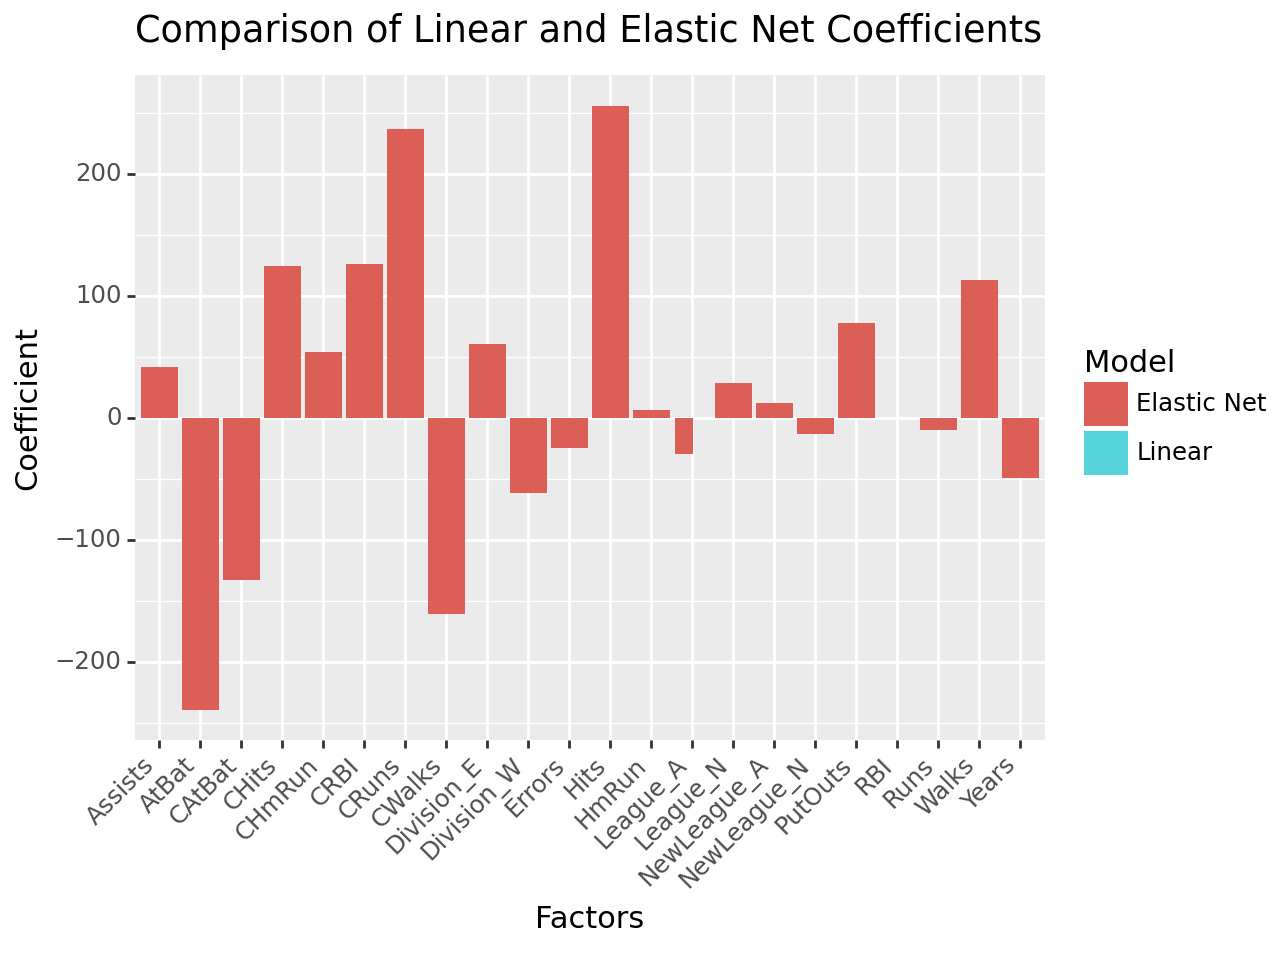

In [535]:
coef_df['Factors'] = coef_df['Factors'].str.replace('standardize__', '').str.replace('dummify__', '')

sorted_coefs_df = pd.DataFrame(lin_sorted_coefs, columns=['Factors', 'Coefficient'])
sorted_coefs_df['Model'] = 'Linear'
coef_df['Model'] = 'Elastic Net'


df_combined = pd.concat([sorted_coefs_df, coef_df])
df_combined['Coefficient'] = pd.to_numeric(df_combined['Coefficient'], errors='coerce')


plot = (ggplot(df_combined) +
        aes(x='Factors', y='Coefficient', fill='Model') +
        geom_bar(stat='identity', position=position_dodge(width=0.8)) +
        labs(title='Comparison of Linear and Elastic Net Coefficients',
             x='Factors',
             y='Coefficient') +
        theme(axis_text_x=element_text(rotation=45, hjust=1))
       )

print(plot)